# Decoder

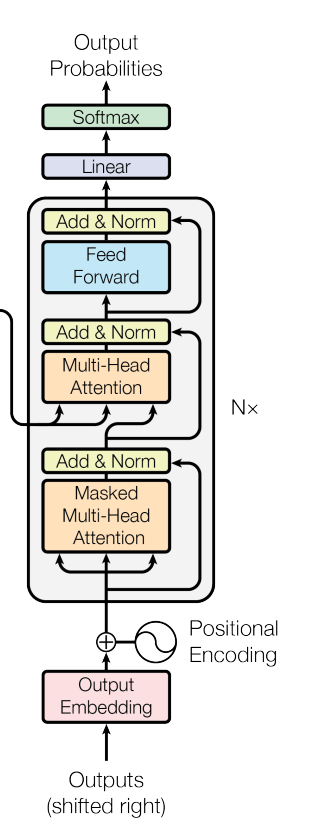

## Masked Multi-Head Attention

멀티 헤드 어텐션에서 사용된 mask와는 다르게 pad 토큰 뿐만 아니라 대각선 요소 위쪽 요소들도 함께 mask가 되어있다.

In [57]:
def decoder_attention_mask(input):
  pad_mask = input.eq(0).unsqueeze(1).expand(input_encoded.size(0), input_encoded.size(1), input_encoded.size(1))

  one_mask = torch.ones_like(input).unsqueeze(1).expand(input.size(0), input.size(1), input.size(1))
  diagonal_mask = one_mask.triu(diagonal = 1)

  decoder_attn_mask = torch.gt((pad_mask+diagonal_mask), 0)
  return decoder_attn_mask

In [59]:
class decoderlayer(nn.Module):
  def __init__(self):
    super().__init__()

    hidden_size = 512
    self.multihead_attn = Mutihead_attention()
    self.layer_norm1 = nn.LayerNorm(hidden_size)
    self.dec_enc_attn = Mutihead_attention()
    self.layer_norm2 = nn.LayerNorm(hidden_size)  
    self.pos_ffn = PoswiseFeedForwardNet()
    self.layer_norm3 =  nn.LayerNorm(hidden_size)

    # dec_attention_mask = 대각선 요소와 pad token을 mask 한 것
    # dec_enc_attn_mask = encoder input과 decoder input을 합쳐 pad token을 mask
  def forward(self, dec_inputs, enc_outputs, dec_attention_mask, dec_enc_attn_mask):
    dec_attn_outputs, self_attn_prob = self.multihead_attn(dec_inputs, dec_inputs, dec_inputs, dec_attention_mask)
    dec_attn_outputs = self.layer_norm1(dec_inputs + dec_attn_outputs)
    dec_enc_attn_outputs, dec_enc_attn_prob = self.dec_enc_attn(dec_attn_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
    dec_enc_attn_outputs = self.layer_norm2(dec_enc_attn_outputs + dec_attn_outputs)
    ffn_outputs = self.pos_ffn(dec_enc_attn_outputs)
    ffn_outputs = self.layer_norm3(ffn_outputs + dec_enc_attn_outputs)

    return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [60]:
def decoder_attention_mask(input):
  pad_mask = input.eq(0).unsqueeze(1).expand(input_encoded.size(0), input_encoded.size(1), input_encoded.size(1))
  one_mask = torch.ones_like(input).unsqueeze(1).expand(input.size(0), input.size(1), input.size(1))
  diagonal_mask = one_mask.triu(diagonal = 1)

  decoder_attn_mask = torch.gt((pad_mask+diagonal_mask), 0)
  return decoder_attn_mask

In [63]:
def decoder_attention_mask(input):
  pad_mask = input.eq(0).unsqueeze(1).expand(input_encoded.size(0), input_encoded.size(1), input_encoded.size(1))

  one_mask = torch.ones_like(input).unsqueeze(1).expand(input.size(0), input.size(1), input.size(1))
  diagonal_mask = one_mask.triu(diagonal = 1)

  decoder_attn_mask = torch.gt((pad_mask+diagonal_mask), 0)
  return decoder_attn_mask

In [64]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()

    n_vocab = tokenizer.vocab_size
    hidden_size = 512
    self.dec_pos = nn.Embedding(n_vocab, hidden_size)

    n_seq = 64
    self.pos_enc = torch.FloatTensor(positional_encoding(n_seq))
    self.pos_emb = nn.Embedding.from_pretrained(self.pos_enc, freeze=True)

    n_layer = 6
    self.layers = nn.ModuleList([decoderlayer() for _ in range(n_layer)])

  def forward(self, dec_inputs, enc_inputs, enc_outputs):
    position =  torch.arange(dec_inputs.size(1)).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous()
    pos_mask = dec_inputs.eq(0)
    position.masked_fill_(pos_mask, 0)

    pos_angle = self.pos_emb(position)
    dec_output = self.dec_pos(dec_inputs) + pos_angle

    pad_mask = dec_inputs.eq(0).unsqueeze(1).expand(dec_inputs.size(0), dec_inputs.size(1), dec_inputs.size(1))
    one_mask = torch.ones_like(dec_inputs).unsqueeze(1).expand(dec_inputs.size(0), dec_inputs.size(1), dec_inputs.size(1))
    diagonal_mask = one_mask.triu(diagonal = 1)
    decoder_attn_mask = torch.gt((pad_mask+diagonal_mask), 0)

    dec_enc_attn_mask = enc_inputs.eq(0)
    dec_enc_attn_mask = dec_enc_attn_mask.unsqueeze(1).expand(dec_inputs.size(0), dec_inputs.size(1), dec_inputs.size(1))

    self_attn_probs, dec_enc_attn_probs = [], []
    for layer in self.layers:
      dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_output, enc_outputs, decoder_attn_mask, dec_enc_attn_mask)
      self_attn_probs.append(self_attn_prob)
      dec_enc_attn_probs.append(dec_enc_attn_prob)
    return dec_output, self_attn_probs, dec_enc_attn_probs